# Probabilistic Layers

> In this post, we will introduce other probabilistic layers and how we can use them.. This is the summary of lecture "Probabilistic Deep Learning with Tensorflow 2" from Imperial College London.

- toc: true 
- badges: true
- comments: true
- author: Chanseok Kang
- categories: [Python, Coursera, Tensorflow_probability, ICL]
- image: images/probabilistic_layer.png

## Packages

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp

import numpy as np
import matplotlib.pyplot as plt

tfd = tfp.distributions
tfpl = tfp.layers

plt.rcParams['figure.figsize'] = (10, 6)

In [3]:
print("Tensorflow Version: ", tf.__version__)
print("Tensorflow Probability Version: ", tfp.__version__)

Tensorflow Version:  2.5.0
Tensorflow Probability Version:  0.13.0


## Overview

### Model with DistributionLambda Layer

```python
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential([
    Dense(16, activation='relu', input_shape=(2, )),
    Dense(2), # (batch_size, 2)
    tfpl.DistributionLambda(
        # Note that ellipse means the batch size
        lambda t: tfd.Independent(tfd.Normal(loc=t[..., :1],
                                             scale=tf.math.softplus(t[..., 1:])))
    )
])

```

Note that `tf.math.softplus` is a smooth version of the relu activation function. And it's strictly positive and injective.
Currently, we didn't set `reinterpreted_batch_ndims` argument in Independent Layer, and default operation with no argument is transfering all batch dimensions except the first into the event shape.

And its output is kind of single random variable with normal distribution.

### Model with IndependentNormal Layer

This is the case of using `IndependentNormal` layer instead of `DistributionLambda` layer

```python
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

model = Sequential([
    Dense(16, activation='relu', input_shape=(2, )),
    Dense(2),
    tfpl.IndependentNormal(1), # Event shape of 1
])
```

Note that, `IndependentNormal` layer is inherit object from a `DistributionLambda` layer.

We can also use it for two dimensional multivariate normal with diagonal covariance matrix.

```python
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

model = Sequential([
    Dense(16, activation='relu', input_shape=(2, )),
    Dense(4), # Now it has 4 dense node, since two for the mean and two for the standard deviation
    tfpl.IndependentNormal(2), # Event shape of 2
])
```

Or we can define the event shape with rank (> 1).

```python
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

model = Sequential([
    Dense(16, activation='relu', input_shape=(2, )),
    Dense(8), 
    tfpl.IndependentNormal([2, 2]), # Event shape of [2, 2]
])
```

General form  is like this:
```python
event_shape = 2
model = Sequential([
    Dense(16, activation='relu', input_shape=(2, )),
    Dense(tfpl.IndependentNormal.params_size(event_shape)),
    tfpl.IndependentNormal(event_shape)
])
```

`param_size` API returns the parameters needed for this probabilistic layer with specific event shape.

If you want to get sample tensor from this Probabilistic Layer, we can use same approach mentioned from previous post. Use `convert_to_tensor_fn` argument.

```python
event_shape = 2
model = Sequential([
    Dense(16, activation='relu', input_shape=(2, )),
    Dense(tfpl.IndependentNormal.params_size(event_shape)),
    tfpl.IndependentNormal(event_shape,
                           convert_to_tensor_fn=tfd.Distribution.sample)
])
```

### Classification Example with MLE

```python
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

num_classes = 10

model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((3, 3)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(tfpl.OneHotCategorical.params_size(num_classes)),
    tfpl.OneHotCategorical(num_classes)
])

model.compile(loss=lambda y_true, y_pred: -y_pred.log_prob(y_true))
model.fit(X_train, y_train, epochs=20)
```

## Tutorial

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import RMSprop

### Create data

The data you'll be working with is artifically created from the following equation:
$$ y_i = x_i + \frac{3}{10}\epsilon_i$$
where $\epsilon_i \sim N(0, 1)$ are independent and identically distributed.

In [5]:
# Create and plot 100 points of training data

X_train = np.linspace(-1, 1, 100)[:, np.newaxis]
y_train = X_train + 0.3 * np.random.randn(100)[:, np.newaxis] # with Gaussian Noise

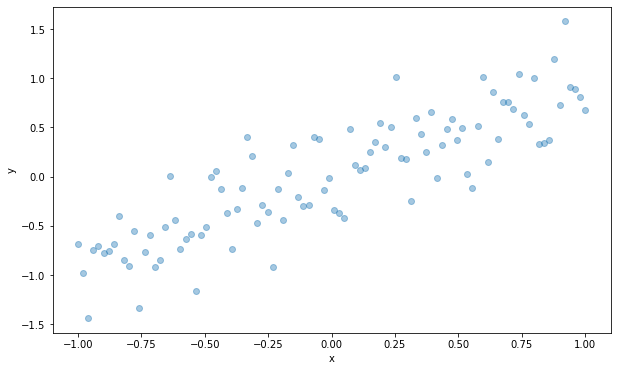

In [6]:
plt.scatter(X_train, y_train, alpha=0.4)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### Baseline - Deterministic linear regression with MSE loss

In [7]:
# Create and train deterministic linear model using mean squared error loss

model = Sequential([
    Dense(units=1, input_shape=(1, ))
])

model.compile(loss=MeanSquaredError(), optimizer=RMSprop(learning_rate=0.005))
model.fit(X_train, y_train, epochs=200, verbose=False)

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


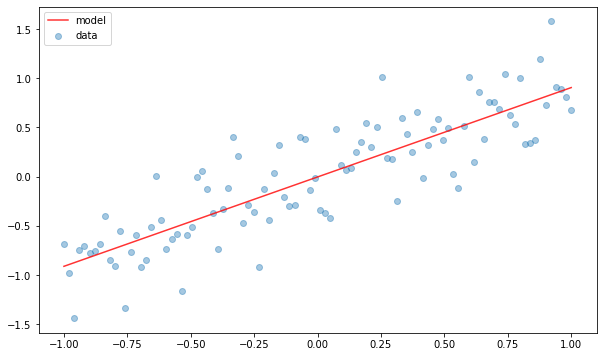

In [8]:
plt.scatter(X_train, y_train, alpha=0.4, label='data')
plt.plot(X_train, model.predict(X_train), color='red', alpha=0.8, label='model')
plt.legend(loc='best')
plt.show()

In [10]:
# Example the model predictions

x = np.array([[0]])
y = model(x)
y

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00379697]], dtype=float32)>

The output of model should contain the uncertainty, not deterministic value. The Deterministic model doesn't have this property, and it always show same value with same input (no uncertainty). In other words, **this model fails to capture the aleatoric uncertainty**, which is, even if I knew the x value and best fit of this regression, I cannot sure what the next point is.

### Probabilistic linear regression with both user-defined and learned variance

In [11]:
# Create probabilistic regression with normal distribution as final layer

# Parameterized Independent normal distribution with specific mean and 1 std (user defined)
model = Sequential([
    Dense(units=1, input_shape=(1, )),
    tfpl.DistributionLambda(lambda t: tfd.Independent(tfd.Normal(loc=t, scale=1)))
], name='probabilistic_regression')

model.summary()

Model: "probabilistic_regression"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 2         
_________________________________________________________________
distribution_lambda (Distrib multiple                  0         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Train model using the negative loglikelihood

def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

In [13]:
model.compile(loss=nll, optimizer=RMSprop(learning_rate=0.005))
model.fit(X_train, y_train, epochs=100, verbose=False)

In [14]:
# Example the distribution created as a feedforward value

y_model = model(x)
y_model

<tfp.distributions.Independent 'probabilistic_regression_distribution_lambda_Independentprobabilistic_regression_distribution_lambda_Normal' batch_shape=[1] event_shape=[1] dtype=float32>

The output is the distribution object, not tensor object.

In [15]:
# Plot the data and a sample from the model

y_model = model(X_train)
y_sample = y_model.sample()
y_hat = y_model.mean()
y_std = y_model.stddev()

y_hat_m2std = y_hat - 2 * y_std
y_hat_p2std = y_hat + 2 * y_std

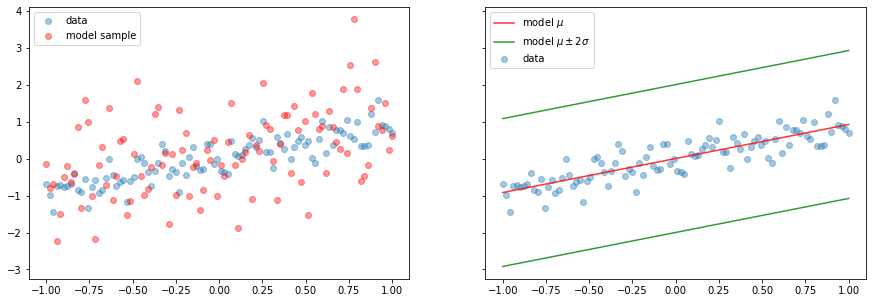

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
ax1.scatter(X_train, y_train, alpha=0.4, label='data')
ax1.scatter(X_train, y_sample, alpha=0.4, color='red', label='model sample')
ax1.legend(loc='best')

ax2.scatter(X_train, y_train, alpha=0.4, label='data')
ax2.plot(X_train, y_hat, color='red', alpha=0.8, label='model $\mu$')
ax2.plot(X_train, y_hat_m2std, color='green', alpha=0.8, label='model $\mu \pm 2 \sigma$')
ax2.plot(X_train, y_hat_p2std, color='green', alpha=0.8)
ax2.legend(loc='best')
plt.show()

Currently, all sampled data from model lies in $2\sigma$ from normal distribution. But it seems to wide besides original dataset distribution. Since we defined standard deviation of normal distribution manually, it make sense.

In order to handle it, we also need to parameterize standard deviation. Note that standard deviation should be positive, its value needs to wrap up `softplus`.

In [18]:
# Create probabilistic regression with normal distribution as final layer

# Parameterized Independent normal distribution with specific mean and std
model = Sequential([
    Dense(units=2, input_shape=(1, )),
    tfpl.DistributionLambda(lambda t: tfd.Independent(tfd.Normal(
        loc=t[..., :1], scale=tf.math.softmax(t[..., 1:]))))
], name='probabilistic_regression_scale')

model.summary()

Model: "probabilistic_regression_scale"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 2)                 4         
_________________________________________________________________
distribution_lambda_1 (Distr multiple                  0         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


Or we can build the sample model with `IndependentNormal` Layer.

In [19]:
event_shape = 1

model = Sequential([
    Dense(units=tfpl.IndependentNormal.params_size(event_shape), input_shape=(1, )),
    tfpl.IndependentNormal(event_shape)
], name='probabilistic_regression_scale')

model.summary()

Model: "probabilistic_regression_scale"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 2)                 4         
_________________________________________________________________
independent_normal (Independ multiple                  0         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.compile(loss=nll, optimizer=RMSprop(learning_rate=0.005))
model.fit(X_train, y_train, epochs=100, verbose=False)

In [21]:
# Plot the data and a sample from the model

y_model = model(X_train)
y_sample = y_model.sample()
y_hat = y_model.mean()
y_std = y_model.stddev()

y_hat_m2std = y_hat - 2 * y_std
y_hat_p2std = y_hat + 2 * y_std

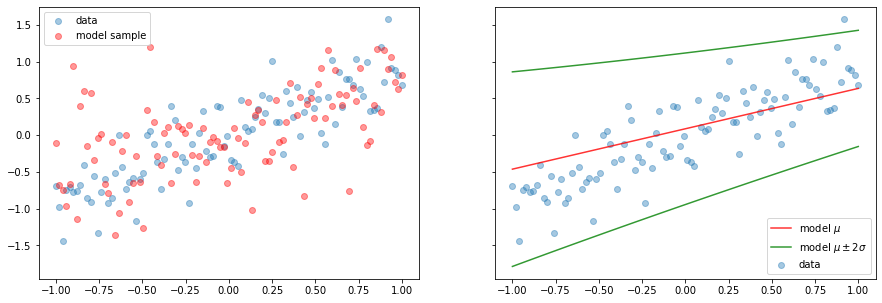

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
ax1.scatter(X_train, y_train, alpha=0.4, label='data')
ax1.scatter(X_train, y_sample, alpha=0.4, color='red', label='model sample')
ax1.legend(loc='best')

ax2.scatter(X_train, y_train, alpha=0.4, label='data')
ax2.plot(X_train, y_hat, color='red', alpha=0.8, label='model $\mu$')
ax2.plot(X_train, y_hat_m2std, color='green', alpha=0.8, label='model $\mu \pm 2 \sigma$')
ax2.plot(X_train, y_hat_p2std, color='green', alpha=0.8)
ax2.legend(loc='best')
plt.show()

In [24]:
model(x).sample()

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.7411721]], dtype=float32)>

In [25]:
model(x).sample()

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.16175717]], dtype=float32)>

### Probabilistic linear regression with nonlinear learned mean & variance

Let's change the data to being nonlinear:
$$ y_i = x_i^3 + \frac{1}{10}(2 + x_i)\epsilon_i$$
where $\epsilon_i \sim N(0, 1)$ are independent and identically distributed.

In [33]:
# Create and plot 1000 data points

X_train = np.linspace(-1, 1, 1000)[:, np.newaxis]
y_train = np.power(X_train, 3) + 0.1 * (2 + X_train) * np.random.randn(1000)[:, np.newaxis]

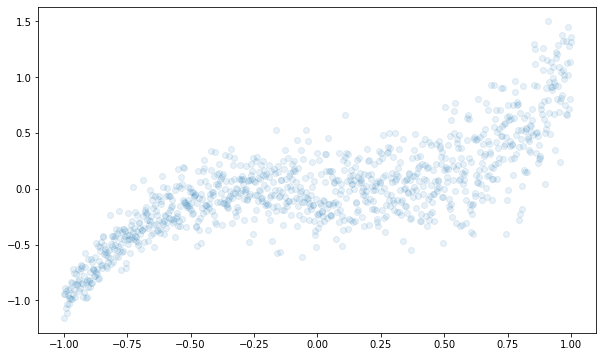

In [34]:
plt.scatter(X_train, y_train, alpha=0.1)
plt.show()

In [35]:
# Create probabilistic regression: normal distribution with fixed variance

event_shape = 1

model = Sequential([
    Dense(units=8, input_shape=(1, ), activation='sigmoid'),
    Dense(tfpl.IndependentNormal.params_size(event_shape)),
    tfpl.IndependentNormal(event_shape)
])

model.compile(loss=nll, optimizer=RMSprop(learning_rate=0.01))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 8)                 16        
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 18        
_________________________________________________________________
independent_normal_2 (Indepe multiple                  0         
Total params: 34
Trainable params: 34
Non-trainable params: 0
_________________________________________________________________


In [36]:
# Train model

model.fit(X_train, y_train, epochs=200, verbose=False)
model.evaluate(X_train, y_train)

32/32 [==============================] - 0s 754us/step - loss: -0.1051


-0.10511082410812378

In [49]:
y_model = model(X_train)
y_sample = y_model.sample()
y_hat = y_model.mean()
y_std = y_model.stddev()
y_hat_m2std = y_hat - 2 * y_std
y_hat_p2std = y_hat + 2 * y_std

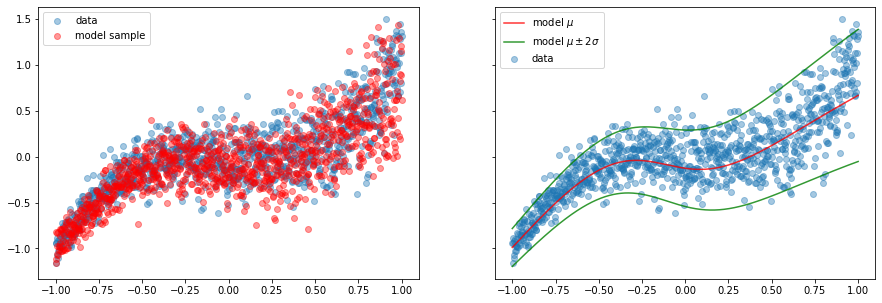

In [50]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
ax1.scatter(X_train, y_train, alpha=0.4, label='data')
ax1.scatter(X_train, y_sample, alpha=0.4, color='red', label='model sample')
ax1.legend(loc='best')

ax2.scatter(X_train, y_train, alpha=0.4, label='data')
ax2.plot(X_train, y_hat, color='red', alpha=0.8, label='model $\mu$')
ax2.plot(X_train, y_hat_m2sd, color='green', alpha=0.8, label='model $\mu \pm 2 \sigma$')
ax2.plot(X_train, y_hat_p2std, color='green', alpha=0.8)
ax2.legend(loc='best')
plt.show()